In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
def reduce_memory_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [35]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)

In [40]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

In [29]:
def missing_data(df):
   total = df.isnull().sum().sort_values(ascending = False)
   percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
   return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [2]:
import gdown
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## POS_CASH_balance.csv

**POS_CASH_balance.csv**
*   Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
*   This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample.

**POS_CASH_balance.csv FEATURE DESCRIPTION**

**SK_ID_PREV:** The ID of previous credit in Home Credit related to loan in our sample

**SK_ID_CURR:** ID of loan in our sample

**MONTHS_BALANCE:** Month of balance relative to application date

**CNT_INSTALMENT:** Term of previous credit (can change over time)

**CNT_INSTALMENT_FUTURE:** Installments left to pay on the previous credit

**NAME_CONTRACT_STATUS:** Contract status during the month

**SK_DPD:** DPD (days past due) during the month of previous credit

**SK_DPD_DEF:** DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

In [33]:
pos_cash = reduce_memory_usage(pd.read_csv('/content/drive/MyDrive/Colab/POS_CASH_balance.csv'))

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%


In [4]:
pos_cash.head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0
7,1387235,153211,-35,36.0,36.0,Active,0,0
8,1220500,112740,-31,12.0,12.0,Active,0,0
9,2371489,274851,-32,24.0,16.0,Active,0,0


In [5]:
pos_cash.shape

(10001358, 8)

In [6]:
pos_cash.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [7]:
pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [8]:
pos_cash.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,10001358.0,1.903217e+06,535846.530722,1000001.0,1434405.0,1896565.0,2368963.0,2843499.0
SK_ID_CURR,10001358.0,2.784039e+05,102763.745090,100001.0,189550.0,278654.0,367429.0,456255.0
MONTHS_BALANCE,10001358.0,-3.501259e+01,26.066570,-96.0,-54.0,-28.0,-13.0,-1.0
CNT_INSTALMENT,9975287.0,1.708965e+01,11.995056,1.0,10.0,12.0,24.0,92.0
CNT_INSTALMENT_FUTURE,9975271.0,1.048384e+01,11.109058,0.0,3.0,7.0,14.0,85.0
SK_DPD,10001358.0,1.160693e+01,132.714043,0.0,0.0,0.0,0.0,4231.0
SK_DPD_DEF,10001358.0,6.544684e-01,32.762491,0.0,0.0,0.0,0.0,3595.0


In [9]:
# check duplicate
pos_cash.duplicated().sum()

0

In [30]:
missing_data(pos_cash)

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
NAME_CONTRACT_STATUS,0,0.000000
SK_DPD,0,0.000000
SK_DPD_DEF,0,0.000000


In [13]:
pos_cash['NAME_CONTRACT_STATUS'].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

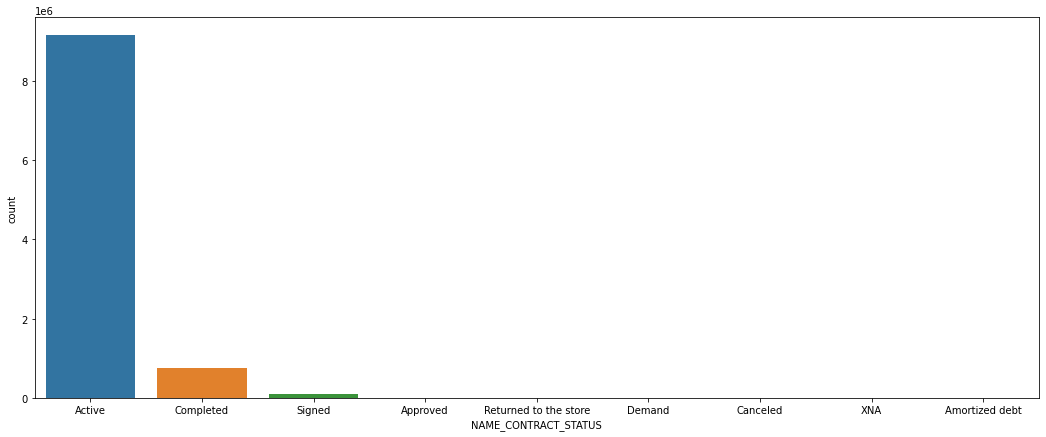

In [14]:
fig, ax = plt.subplots(figsize = (18, 7))
sns.countplot(x = 'NAME_CONTRACT_STATUS', data = pos_cash)
plt.show()

**Merging the TARGETS from application_train to POS_CASH_balance table.**

In [32]:
application_train = reduce_memory_usage(pd.read_csv('/content/drive/MyDrive/Colab/application_train.csv'))

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


In [37]:
print("-"*100)
print("Merging TARGET with POS_CASH_balance Table")
pos_cash_merged = application_train.iloc[:,:2].merge(pos_cash, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with POS_CASH_balance Table
----------------------------------------------------------------------------------------------------


**Correlation Matrix of Features**

----------------------------------------------------------------------------------------------------


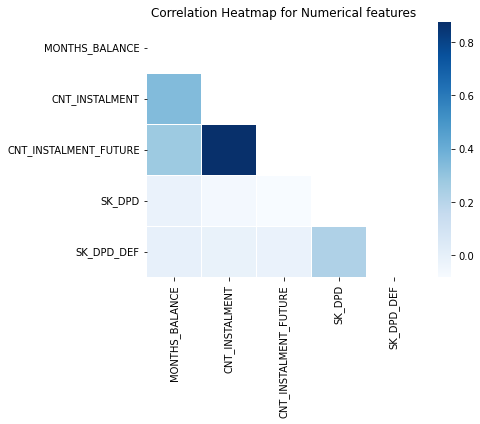

----------------------------------------------------------------------------------------------------


In [38]:
corr_mat = correlation_matrix(pos_cash_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (7,6))
corr_mat.plot_correlation_matrix()

**Comment**
* From the heatmap of correlation matrix, we one set of moderately correlated features, which are: CNT_INSTALMENT and CNT_INSTALMENT_FUTURE.

* The correlation of features with Target is very low, this shows the absence of a linear relationship between the feature and the target variable.

**Plotting Continuous Variables**

Firstly we will group by the 'SK_ID_PREV' field and aggregate with mean, so that we get an averaged row for each of the previous loan that the client had.

#### CNT_INSTALMENT_FUTURE

In [ ]:
plot_continuous_variables(pos_cash_merged, 'CNT_INSTALMENT_FUTURE', plots = ['box'], figsize = (8,8))
del pos_cash_merged

In [39]:
pos_cash_merged = pos_cash_merged.groupby('SK_ID_PREV').mean()

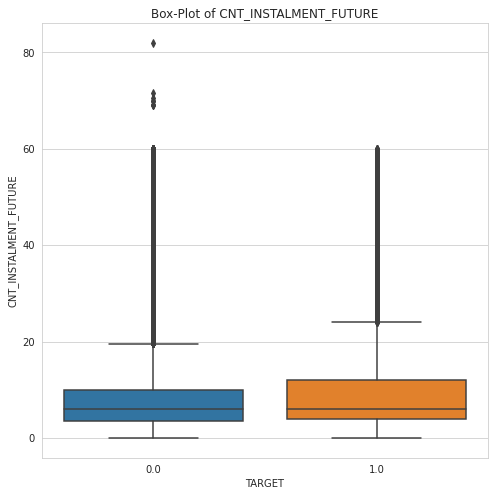

In [41]:
plot_continuous_variables(pos_cash_merged, 'CNT_INSTALMENT_FUTURE', plots = ['box'], figsize = (8,8))
del pos_cash_merged

**Comment**

Looking at the above box-plot for CNT_INSTALMENT_FUTURE, we see that the percentile values>50% for Defaulters are usually higher than those of Non-Defaulters. Even the upper limit whisker for Defaulters is higher than that of Non-Defaulters. This suggests that the Defaulters tend to have more number of Installments remaining on their previous credits as compared to Non-Defaulters.

#### MONTHS_BALANCE

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


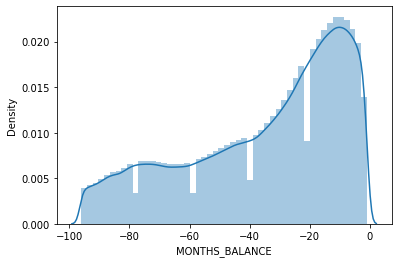

In [15]:
sns.distplot(pos_cash.MONTHS_BALANCE)